In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch

In [7]:
scene_df = pd.read_hdf('scene2.hdf5')
calibration_df = pd.read_hdf('calibration_set_2.hdf5')
calibration_df2 = pd.read_hdf('calibration_set_1.hdf5')

In [29]:


def estimate_parameters(calibration_images, calibration_temperatures):
    # Ensure calibration_images is a numeric array
    calibration_images = np.array(calibration_images.tolist(), dtype=np.float32)
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)
    
    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = torch.tensor(calibration_images, dtype=torch.float32).cuda()
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).cuda()
    
    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.cuda()

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).cuda()], dim=1)
    
    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]
    
    # Reshape back to original image shape
    offsets = offsets.view(height, width).cpu().numpy()
    responsivities = responsivities.view(height, width, -1).cpu().numpy()
    
    return offsets, responsivities




In [43]:
# Process each scene image
calibration_images = calibration_df['image'].values
calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T

of1,g1 = estimate_parameters(calibration_images,calibration_temperatures)

In [31]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    scene_image_tensor = torch.tensor(scene_image, dtype=torch.float32).cuda()
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).cuda()
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).cuda()
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).cuda()
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).cuda()
    
    height, width = scene_image_tensor.shape
    corrected_image_tensor = torch.zeros_like(scene_image_tensor)
    
    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor
    
    # Apply correction
    corrected_image_tensor = scene_image_tensor - expected_value
    
    # Convert the result back to a numpy array if needed
    corrected_image = corrected_image_tensor.cpu().numpy()
    
    return corrected_image



In [32]:
def evaluate_distributions(array):
    """
    This function evaluates and visualizes the distribution of values in a 2D array.

    Parameters:
    array (numpy.ndarray): A 2D numpy array of values.

    Returns:
    None
    """

    # Flatten the 2D array to 1D for distribution analysis
    flattened_array = array.flatten()

    # Calculate basic statistics
    mean = np.mean(flattened_array)
    median = np.median(flattened_array)
    std_dev = np.std(flattened_array)

    # Print basic statistics
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {std_dev}")

    # Plot the histogram of the values
    plt.hist(flattened_array, bins=30, edgecolor='black')
    plt.title('Distribution of Values in 2D Array')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    return mean, median, std_dev

In [33]:
import cv2
import numpy as np

def video_to_stack(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)
    cap.release()
    return np.stack(frames, axis=0)

In [34]:
def generate_array(shape, mean, median, std_dev):
    array = np.random.normal(loc=mean, scale=std_dev, size=shape)
    adjustment = median - np.median(array)
    adjusted_array = array + adjustment
    return adjusted_array

In [5]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [44]:
avg_black_body_temp = calibration_df['t_cn'].mean()

# Process each scene image
corrected_scene_images = []
for index, row in scene_df.iterrows():
    scene_image = row['image']
    scene_temp = row['t_fpa']
    
    corrected_image = apply_correction(scene_image, of1, g1, scene_temp, avg_black_body_temp)
    corrected_scene_images.append(corrected_image)
    
# Convert corrected_scene_images to numpy array
corrected_scene_images = np.array(corrected_scene_images)

Mean: 6569.33740234375
Median: 6561.88818359375
Standard Deviation: 249.6786346435547


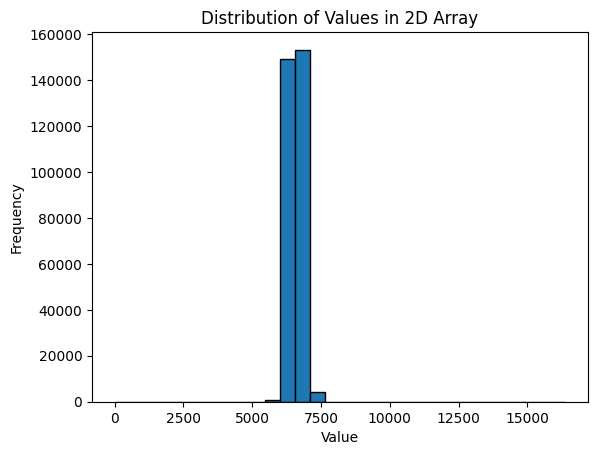

Mean: -59.542728424072266
Median: -59.689720153808594
Standard Deviation: 7.418224811553955


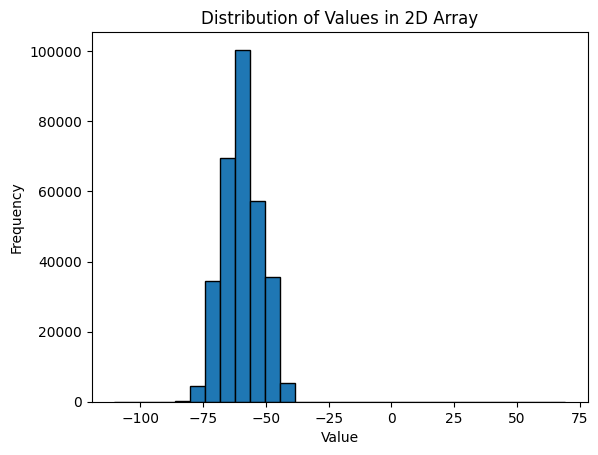

Mean: 13.277923583984375
Median: 13.290410995483398
Standard Deviation: 0.25911587476730347


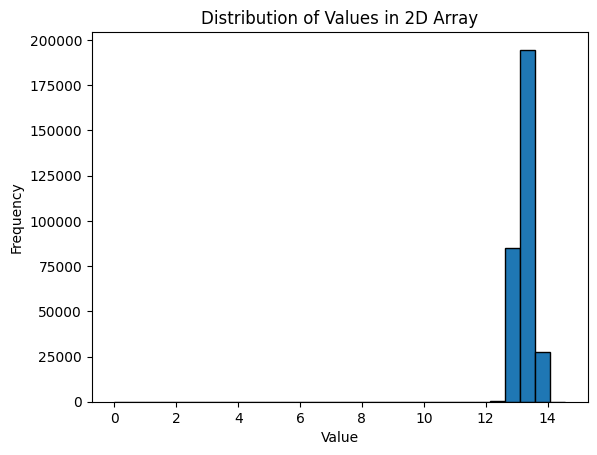

(480, 640, 2)
(480, 640)
(480, 640)
(480, 640)


In [37]:
meanof, medianof, std_devof = evaluate_distributions(of1)
shapeof = of1.shape
meang1,mediang1,std_devg1 = evaluate_distributions(g1[:,:,0])
shapeg1 = g1[:,:,0].shape
meang2,mediang2,std_devg2 = evaluate_distributions(g1[:,:,1])
shapeg2 = g1[:,:,1].shape
print(g1.shape)
print(shapeg1)
print(shapeg2)
print(shapeof)

In [38]:
random_g1 = generate_array(shapeg1, meang1,mediang1,std_devg1)
random_g2 = generate_array(shapeg2, meang2,mediang2, std_devg2)
random_of = generate_array(shapeof, meanof, medianof,std_devof)
random_g = np.stack((random_g1, random_g2), axis=-1)

In [39]:
path = "output-matching.avi"

stacked = video_to_stack(path)

In [40]:
avg_black_body_temp = calibration_df['t_cn'].mean()
scene_temp = 20
# Process each scene image
corrected_scene_images = []
for img in stacked:
    corrected_image = apply_correction(img, random_of, random_g, scene_temp, avg_black_body_temp)
    corrected_scene_images.append(corrected_image)

# Convert corrected_scene_images to numpy array
corrected_scene_images = np.array(corrected_scene_images)



In [8]:
save_video_from_images(scene_df["image"],"scene2.avi")